In [1]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Paramter

In [3]:
RELOAD_DATA = True
DATA_PATH = "data/"

## draw

In [4]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Metrics

In [5]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,attack_indx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    attack = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    attack[attack_indx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(attack, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(attack, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(attack, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(attack, pred))
    
    accuracy = (tp + tn) / len(attack)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy,precision,recall,f1

# Data

In [6]:
SWaT_2019_df = pd.read_pickle(DATA_PATH + "swat_2019_attack_df.pkl")

In [7]:
SWaT_2019_df

,FIT 401,LIT 301,P601 Status,MV201,P101 Status,MV 501,P301 Status,Timestamps
0,0.781740,730.702100,1,2,2,2,1,2019-07-20 04:30:00.000000000
1,0.782380,730.902344,1,2,2,2,1,2019-07-20 04:30:01.000000000
2,0.783021,732.344300,1,2,2,2,1,2019-07-20 04:30:02.004013000
3,0.783021,732.704800,1,2,2,2,1,2019-07-20 04:30:03.004013000
4,0.781228,732.744800,1,2,2,2,1,2019-07-20 04:30:04.000000000
...,...,...,...,...,...,...,...,...
14991,0.809271,883.227051,1,2,2,2,2,2019-07-20 08:39:55.001007000
14992,0.809271,883.227051,1,2,2,2,2,2019-07-20 08:39:56.005004800
14993,0.809271,883.387268,1,2,2,2,2,2019-07-20 08:39:57.005004800
14994,0.808631,883.908000,1,2,2,2,2,2019-07-20 08:39:58.005004800


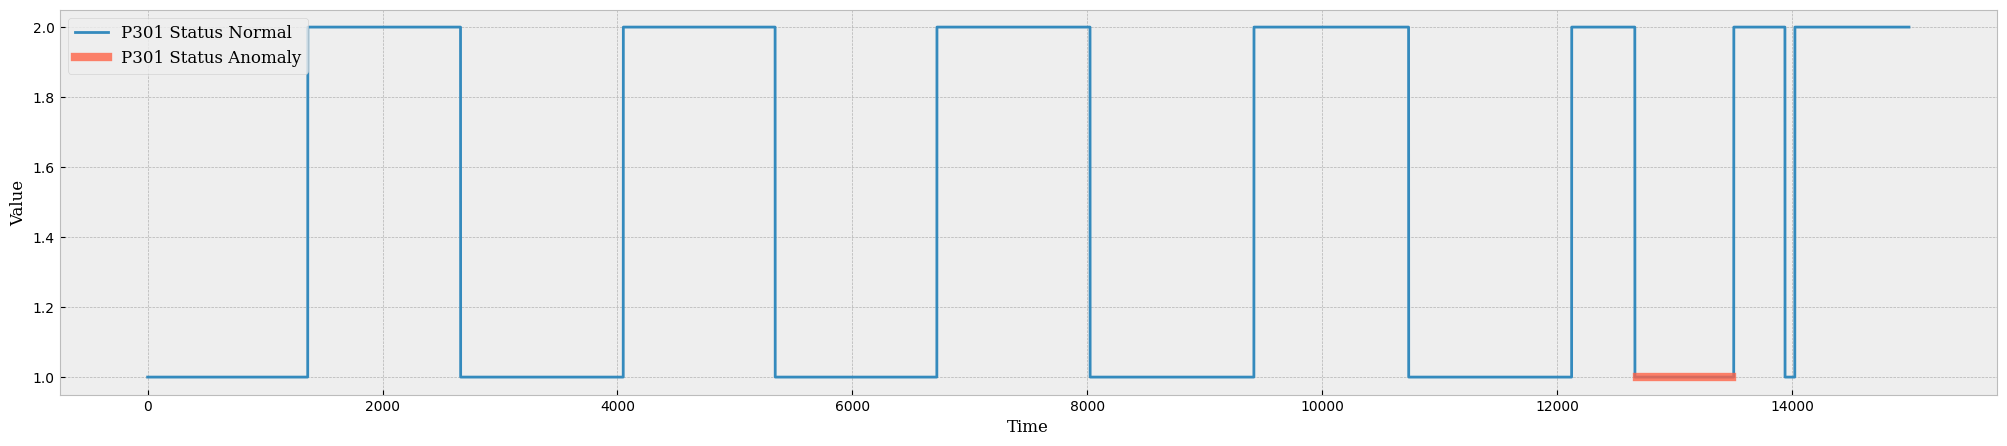

In [8]:
anomaly_feature = 'P301 Status'
anomaly_time = [np.array('2019-07-20 08:01:26', dtype=np.datetime64),
                np.array('2019-07-20 08:14:50', dtype=np.datetime64)]

with plt.style.context('bmh'):
    font = {'size': 12, 'family': 'serif'}
    font_legend = {'size': 12, 'family': 'serif'}
    fig, axs = plt.subplots(1, 1, figsize=(25,5))
    
    start_attack_time = anomaly_time[0]
    end_attack_time = anomaly_time[1]
    attack_df = SWaT_2019_df[SWaT_2019_df["Timestamps"] >= start_attack_time]
    attack_df = attack_df[attack_df["Timestamps"] <= end_attack_time]
    attack_indx =list(attack_df.index)


    axs.plot(SWaT_2019_df[anomaly_feature],
             label='{} Normal'.format(anomaly_feature))
             
    axs.plot(SWaT_2019_df[anomaly_feature].loc[attack_indx],
             label='{} Anomaly'.format(anomaly_feature),
             color='tomato', 
             linewidth=6,
             alpha=0.8)
    axs.set_xlabel('Time', fontdict=font)
    axs.set_ylabel('Value', fontdict=font)
    axs.legend(loc='upper left', prop=font_legend)
    plt.show();

## Extract Features

In [9]:
ts = pd.DataFrame(SWaT_2019_df,columns=[anomaly_feature,'Timestamps'])
ts['id'] = 1

In [10]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_sort='Timestamps',column_value=anomaly_feature)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████| 1/1 [02:54<00:00, 174.78s/it]


In [11]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=[f'{anomaly_feature}__mean',
                                                                     f'{anomaly_feature}__median',
                                                                     f'{anomaly_feature}__variance',
                                                                     f'{anomaly_feature}__standard_deviation',
                                                                     f'{anomaly_feature}__mean_change',
                                                                     f'{anomaly_feature}__kurtosis',
                                                                     f'{anomaly_feature}__minimum',
                                                                     f'{anomaly_feature}__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: anomaly_feature})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','mean_change',
                                      'kurtosis','minimum','maximum']

In [12]:
extracted_relevant_feature

,P301 Status
mean,1.477527
median,1.000000
variance,0.249495
standard_deviation,0.499495
mean_change,0.000067
kurtosis,-1.992167
minimum,1.000000
maximum,2.000000


👉 Phương sai trung bình


👉 mean_change <<< sự thay đổi xung quanh giá trị mean khá đều đặn

👉 kurtosis < 0 phân bố dữ liệu đều


# Top-down

## <span style="color: green; font-size: 24px;">&#10004;</span>Best

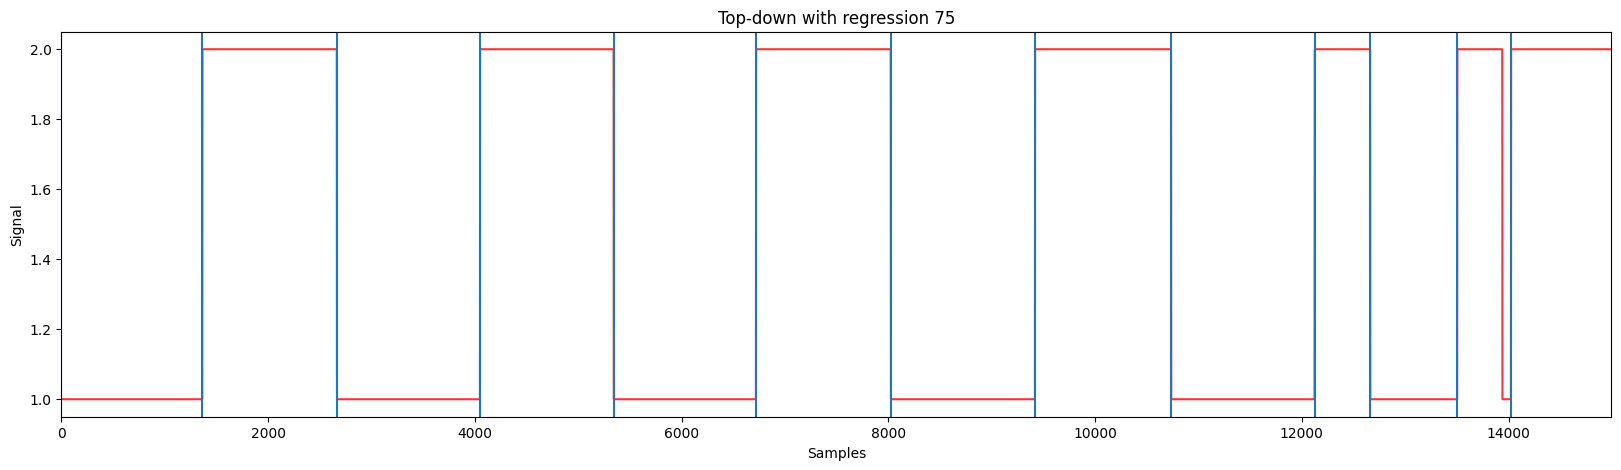

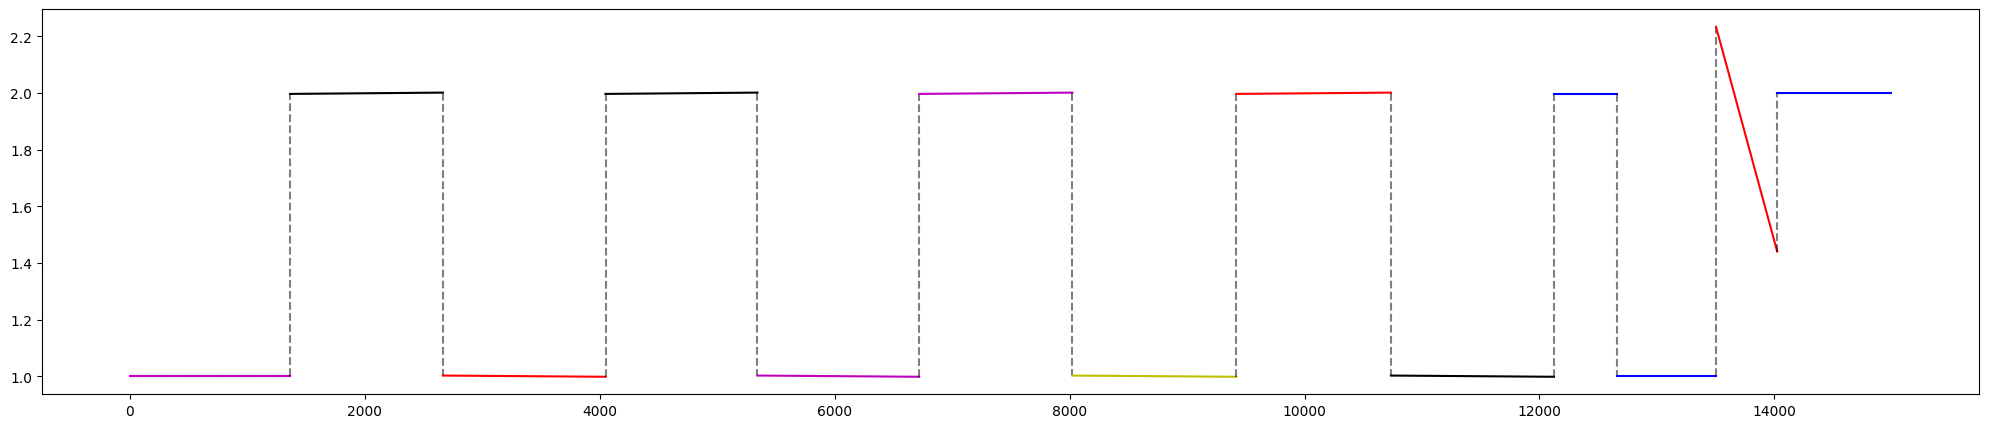

(0.9975326753801014, 0.9560047562425684, 1.0, 0.9775075987841946)

In [16]:
max_error = 75
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_topdown,pre_topdown,recall_topdown,f1_topdown

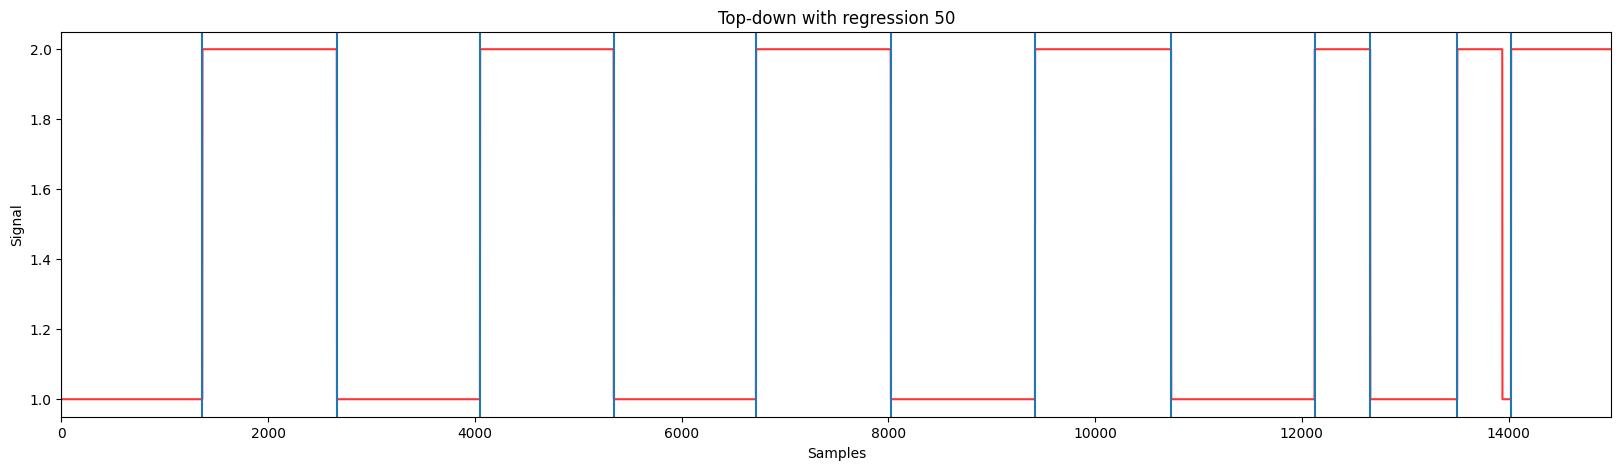

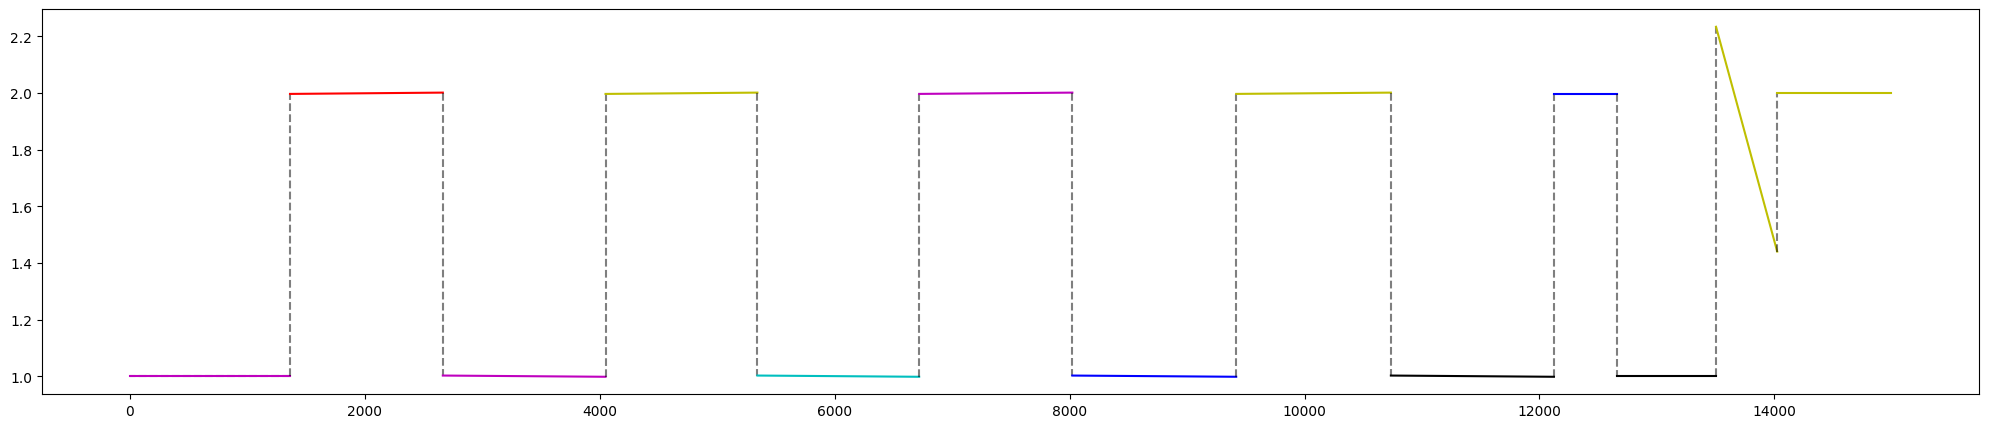

(0.9975326753801014, 0.9560047562425684, 1.0, 0.9775075987841946)

In [50]:
max_error = 50
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_topdown,pre_topdown,recall_topdown,f1_topdown

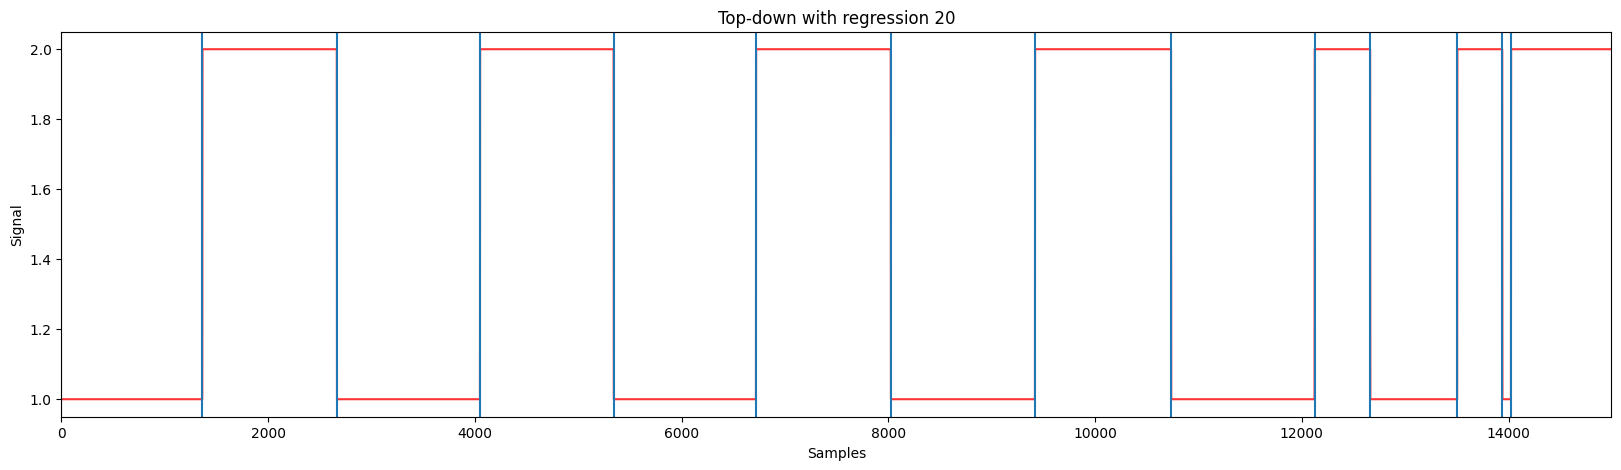

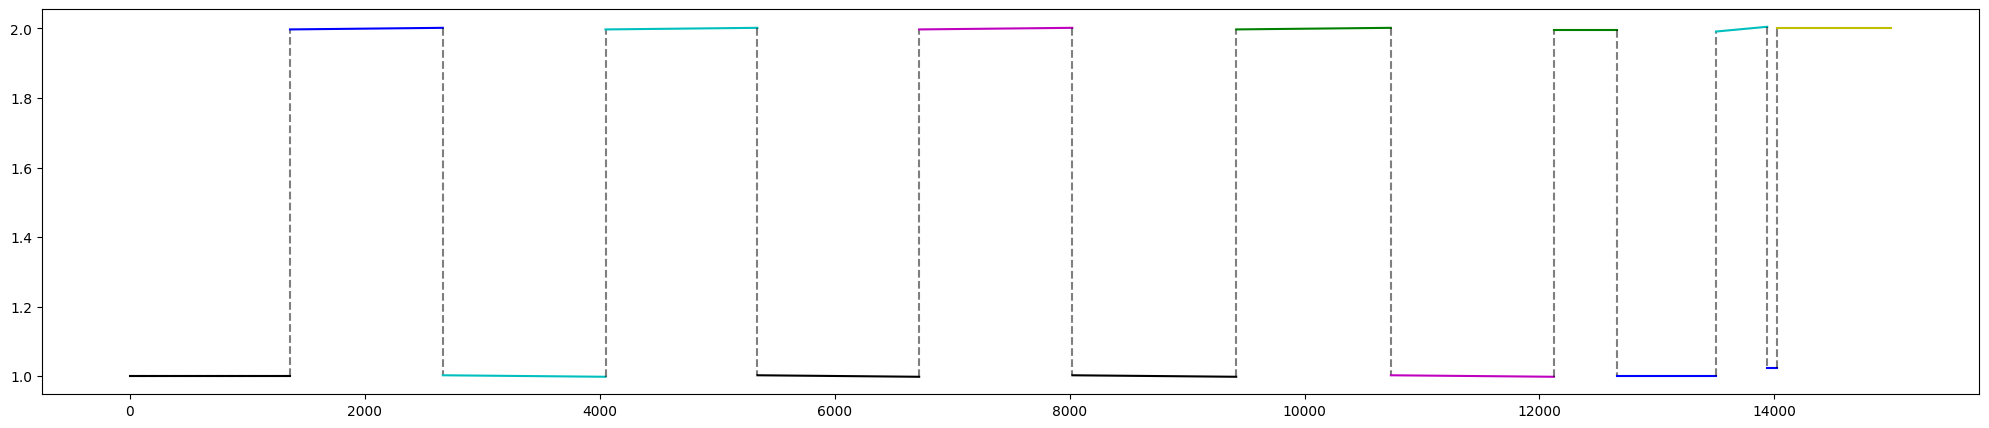

(0.853360896238997, 0.0, 0.0, 0)

In [17]:
max_error = 20
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_topdown,pre_topdown,recall_topdown,f1_topdown

# Bottom-up

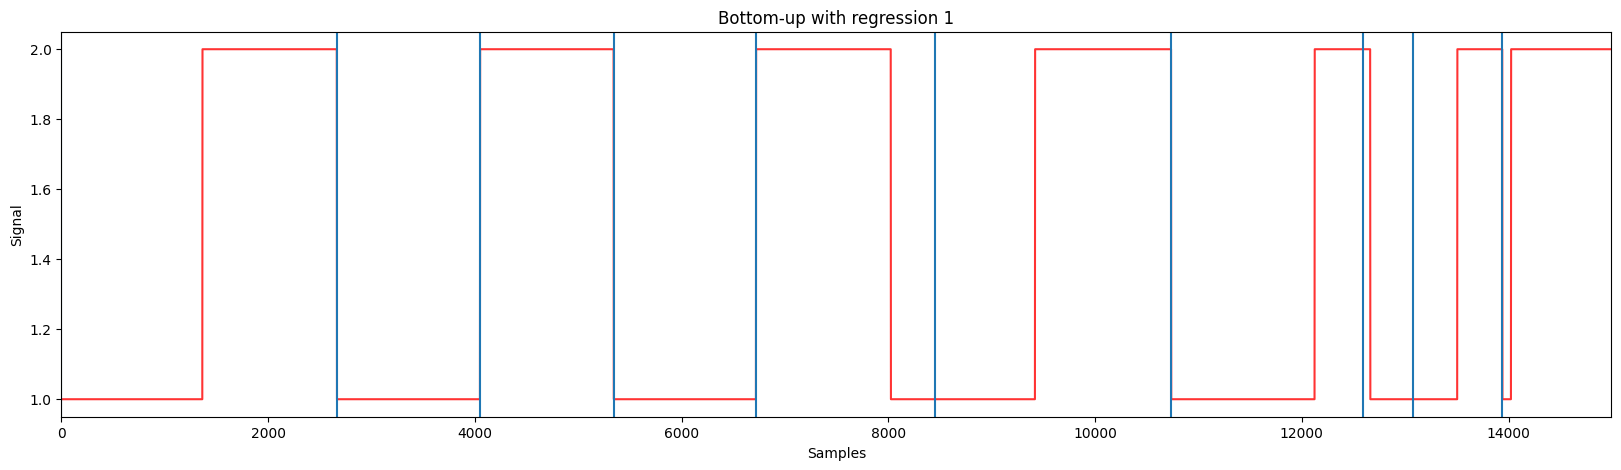

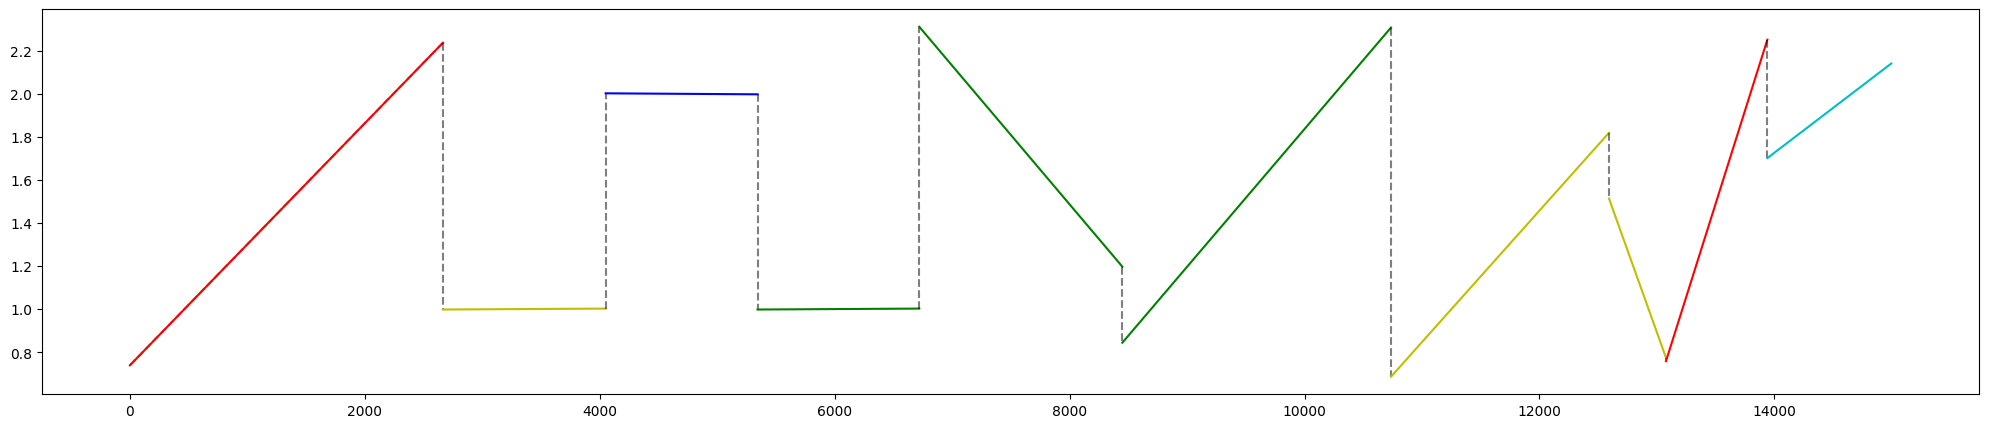

(0.8545612163243531, 0.0, 0.0, 0)

In [47]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu 

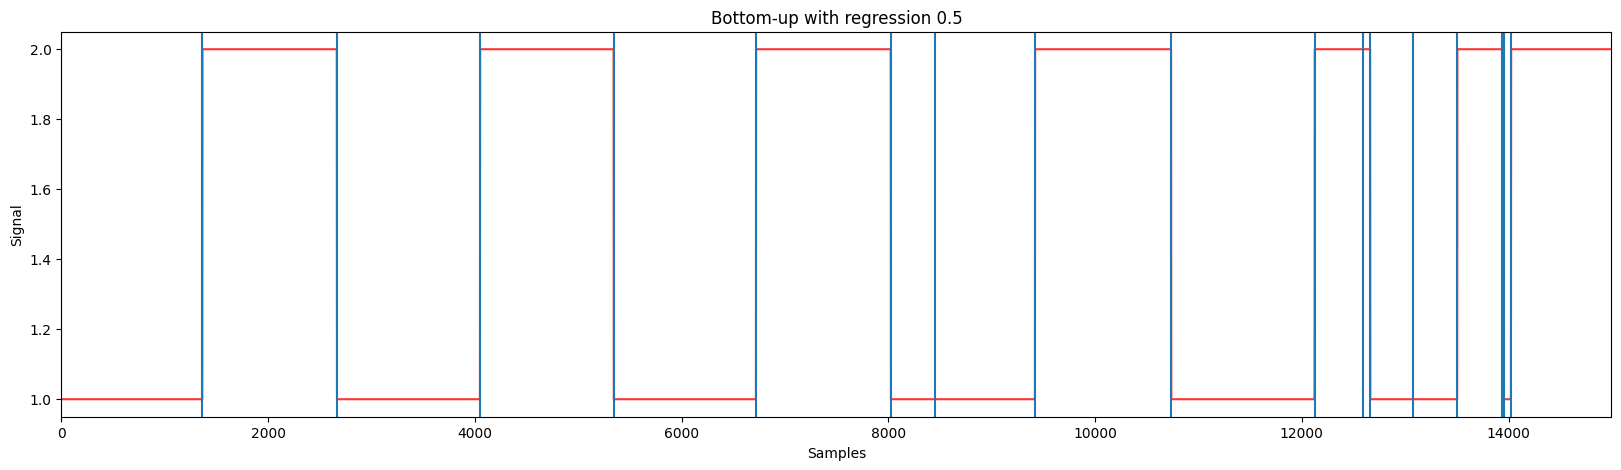

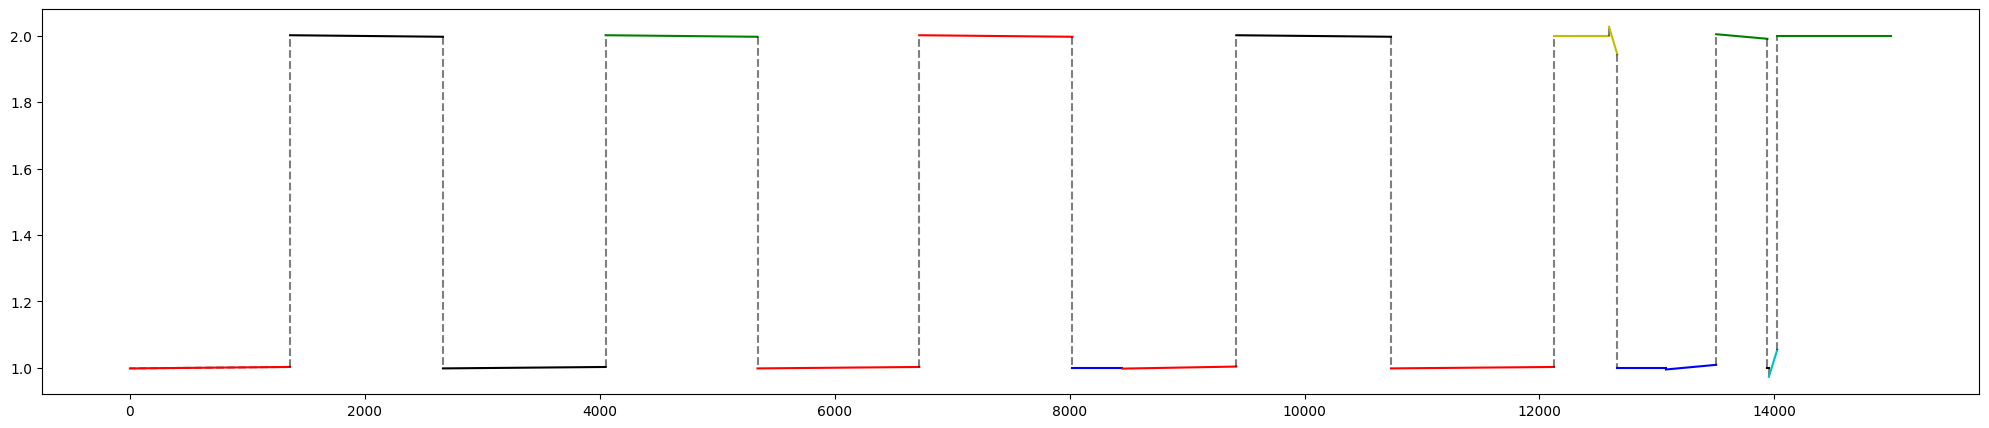

(0.8540277407308615, 0.0, 0.0, 0)

In [26]:
max_error = 0.5
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu 

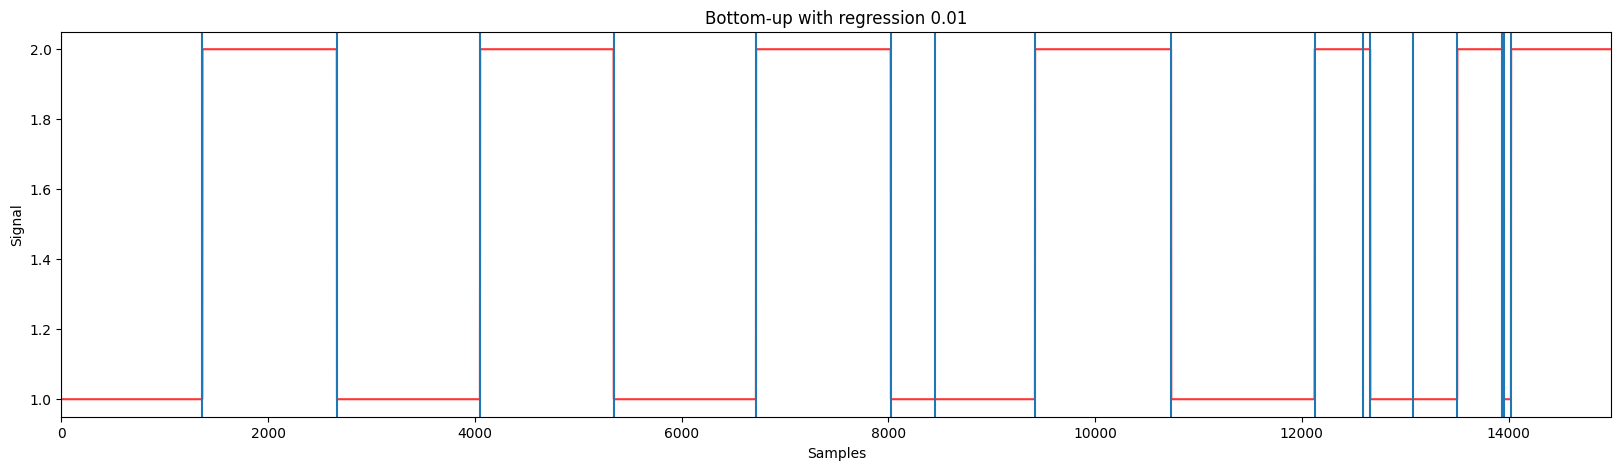

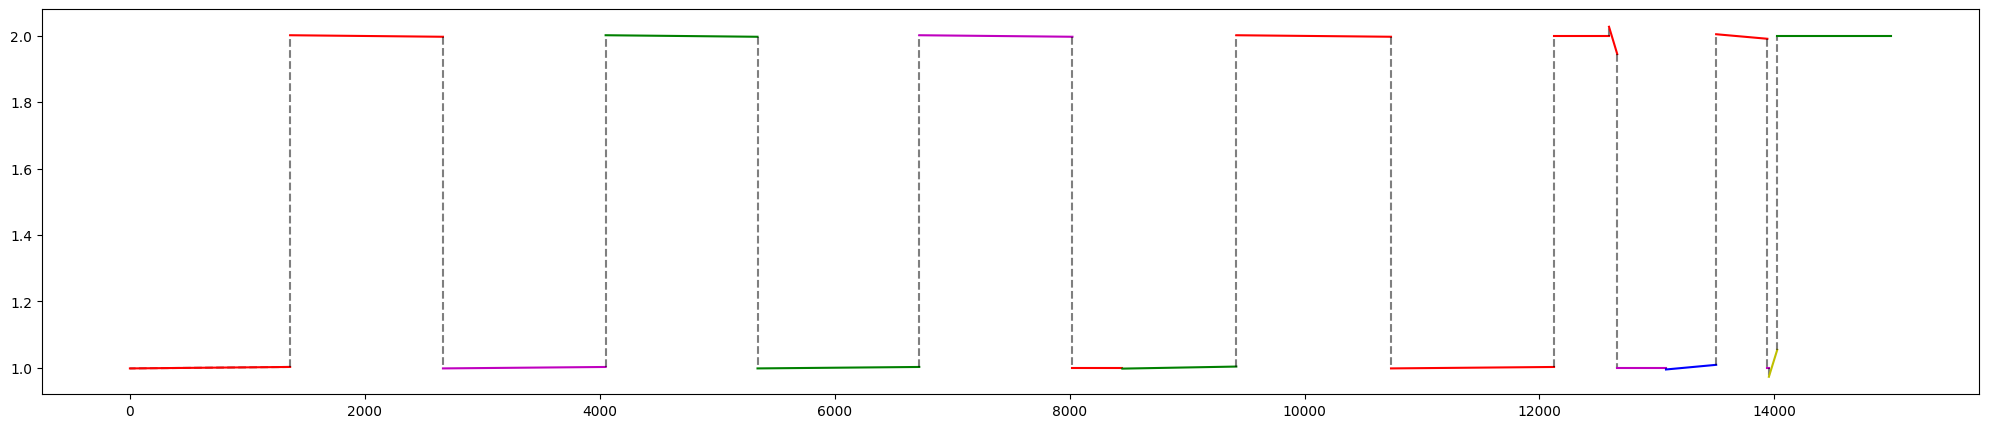

(0.8540277407308615, 0.0, 0.0, 0)

In [23]:
max_error = 0.01
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_btu,pre_btu,recall_btu,f1_btu 

# Sliding Window

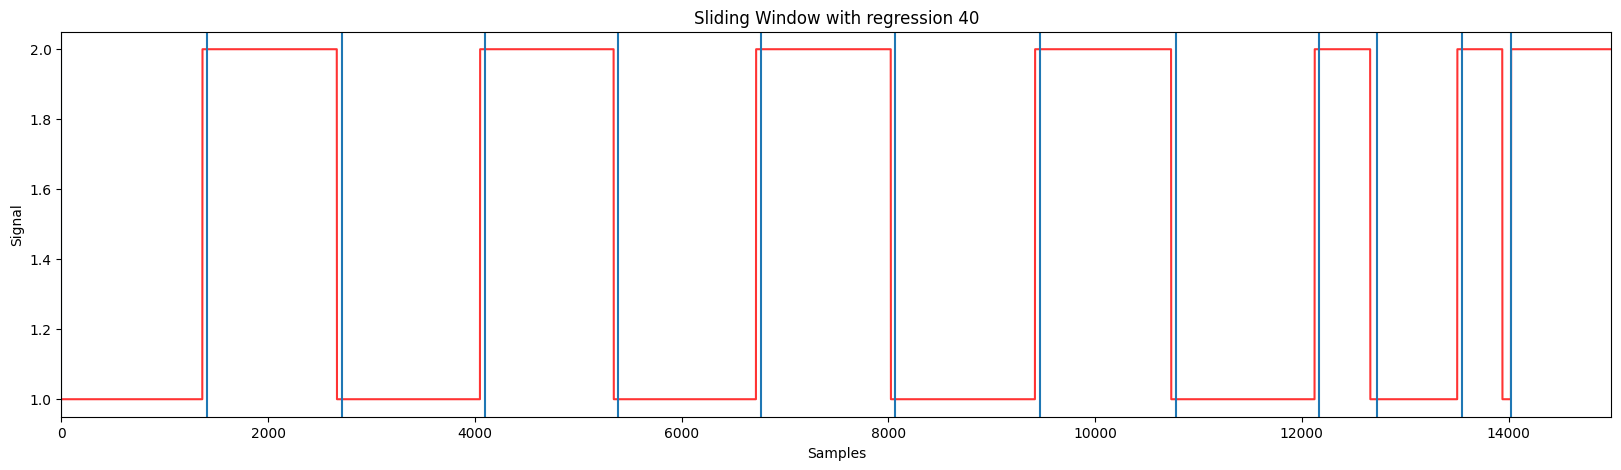

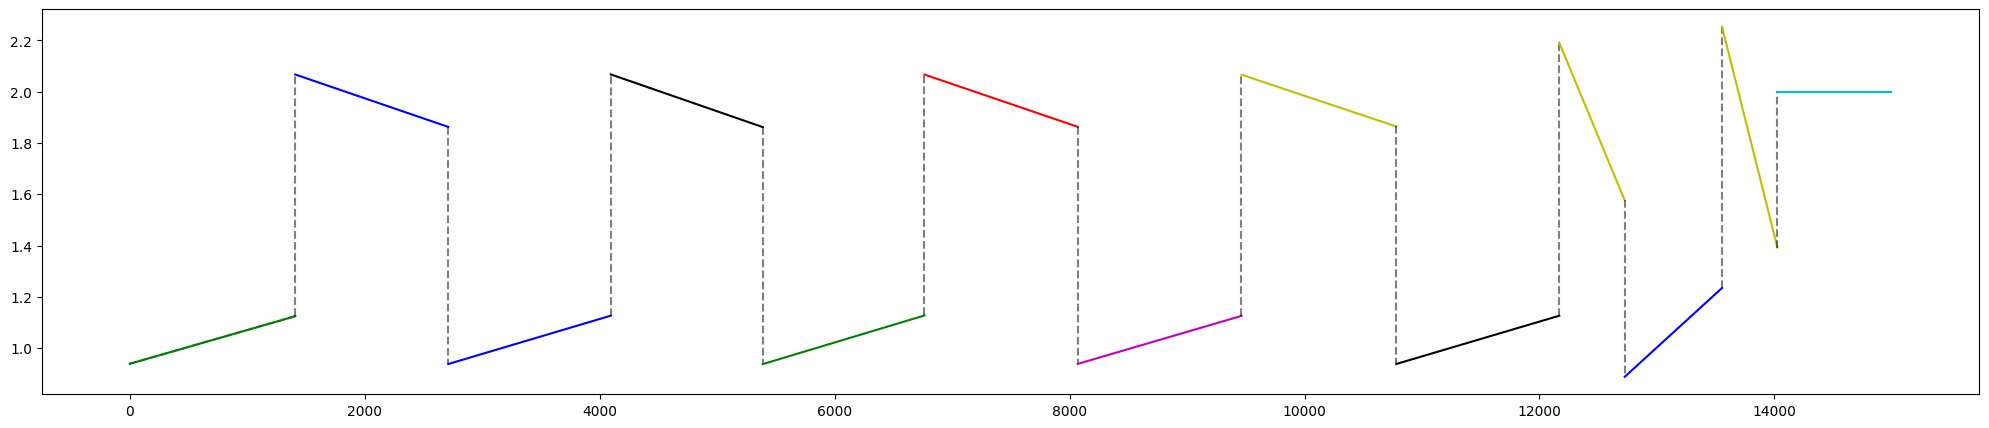

(0.8538943718324886, 0.0, 0.0, 0)

In [30]:
max_error = 40
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

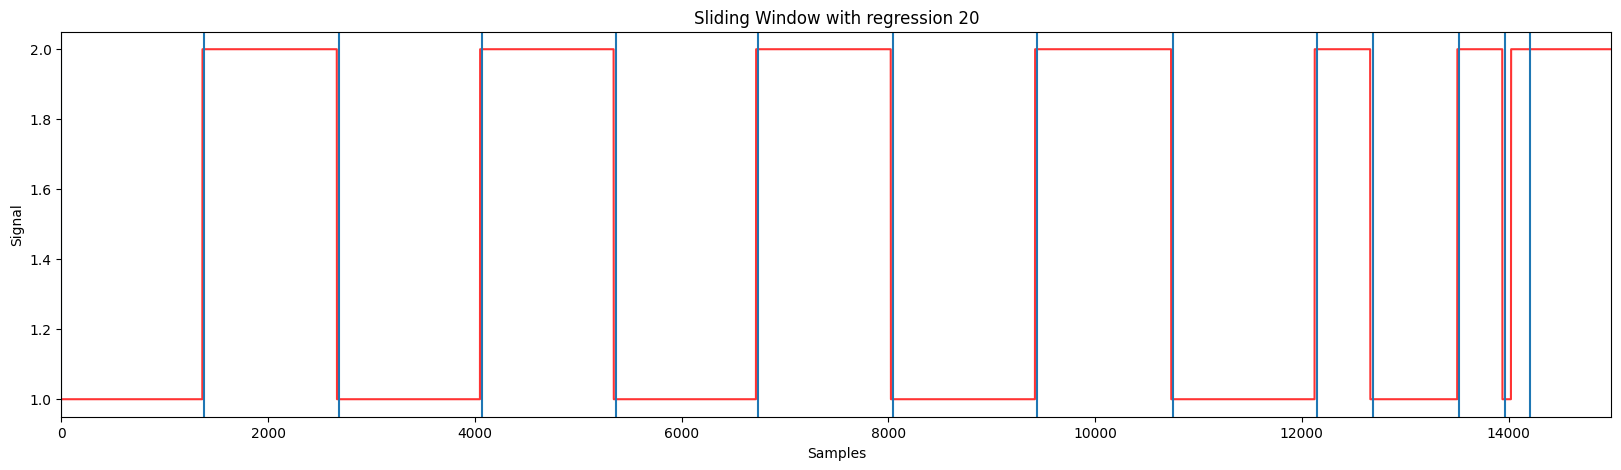

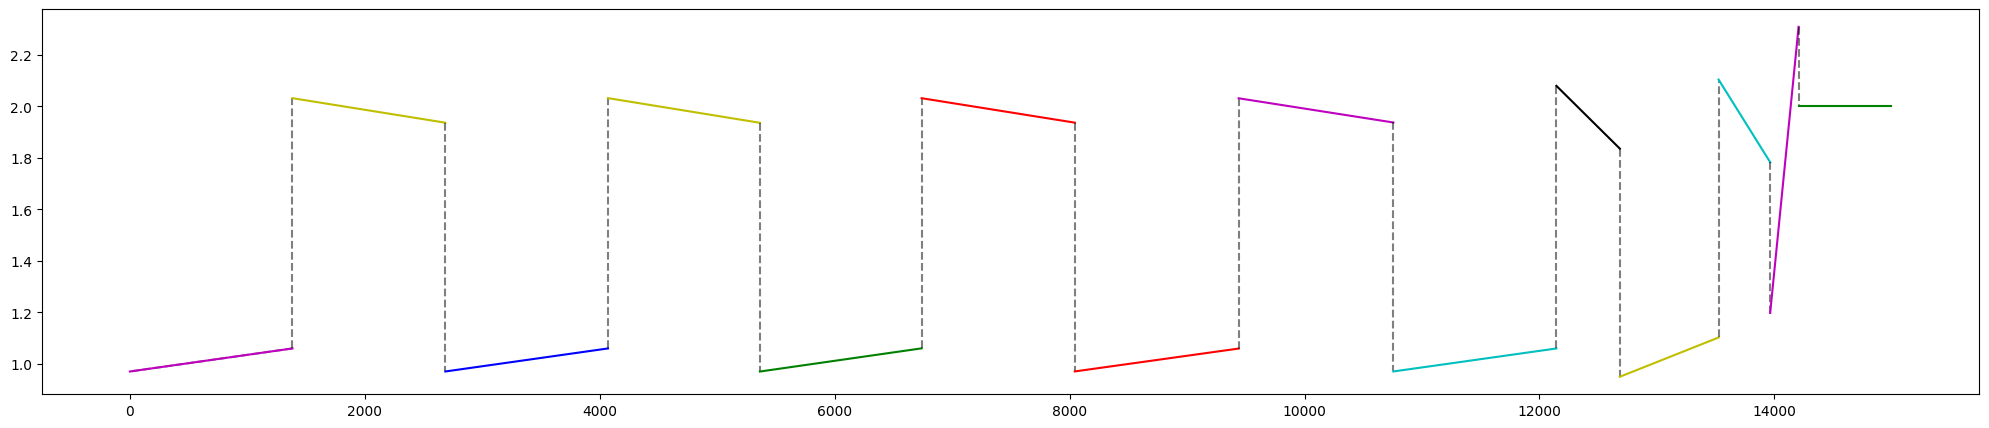

(0.8538276873833022, 0.0, 0.0, 0)

In [28]:
max_error = 20
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

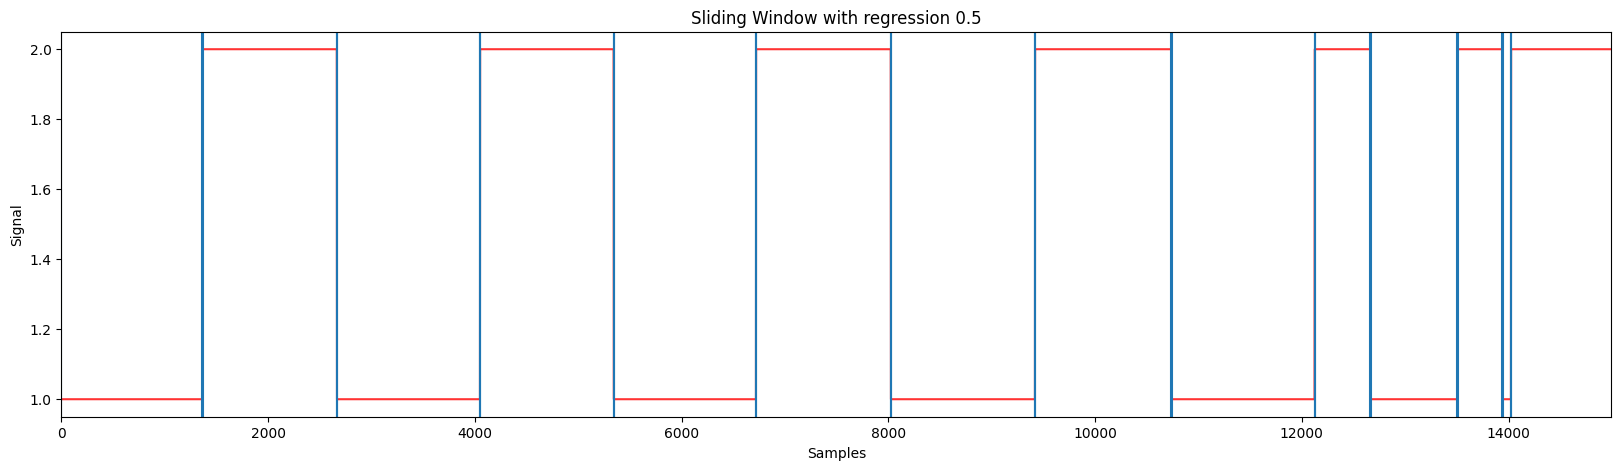

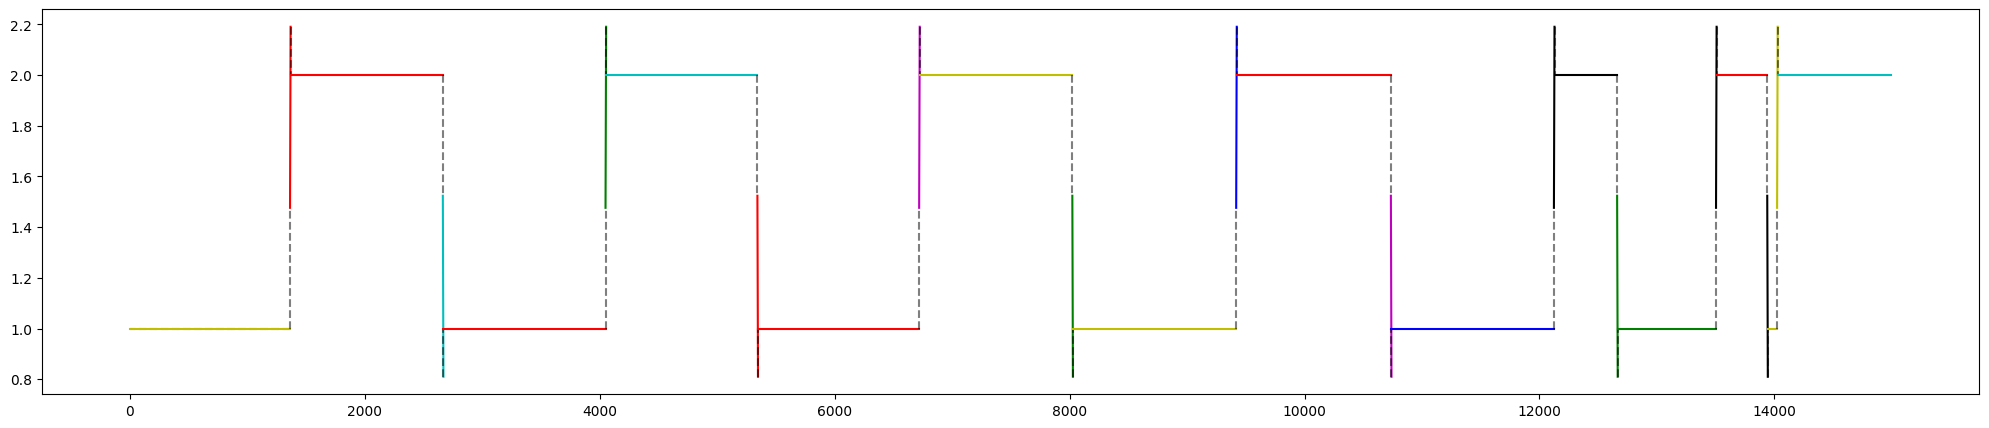

(0.9460522806081622, 0.0, 0.0, 0)

In [32]:
max_error = 0.5
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_sldw,pre_sldw,recall_sldw,f1_sldw

# SWAB

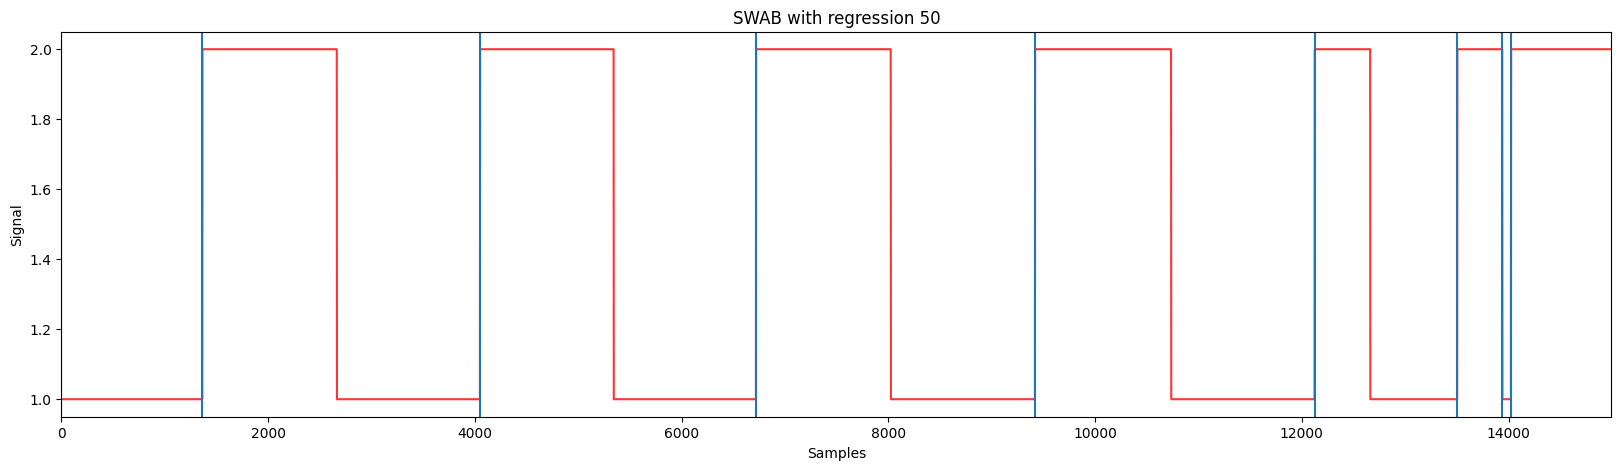

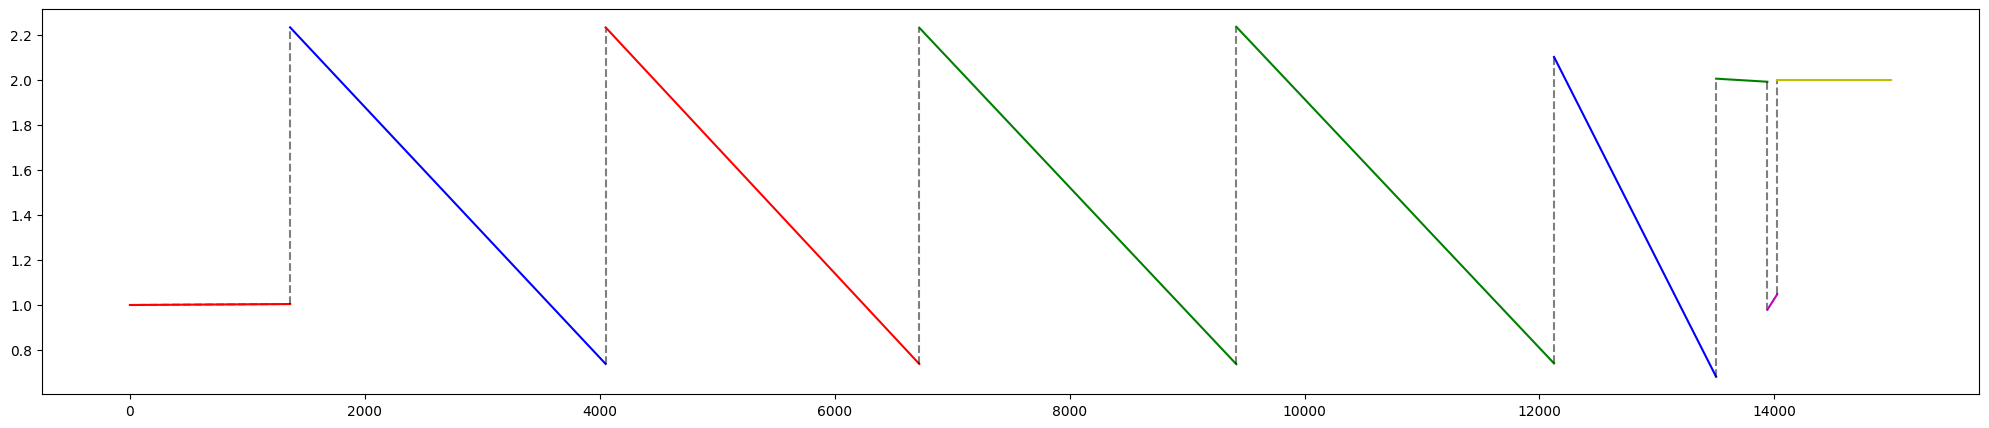

In [38]:
max_error = 50
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)

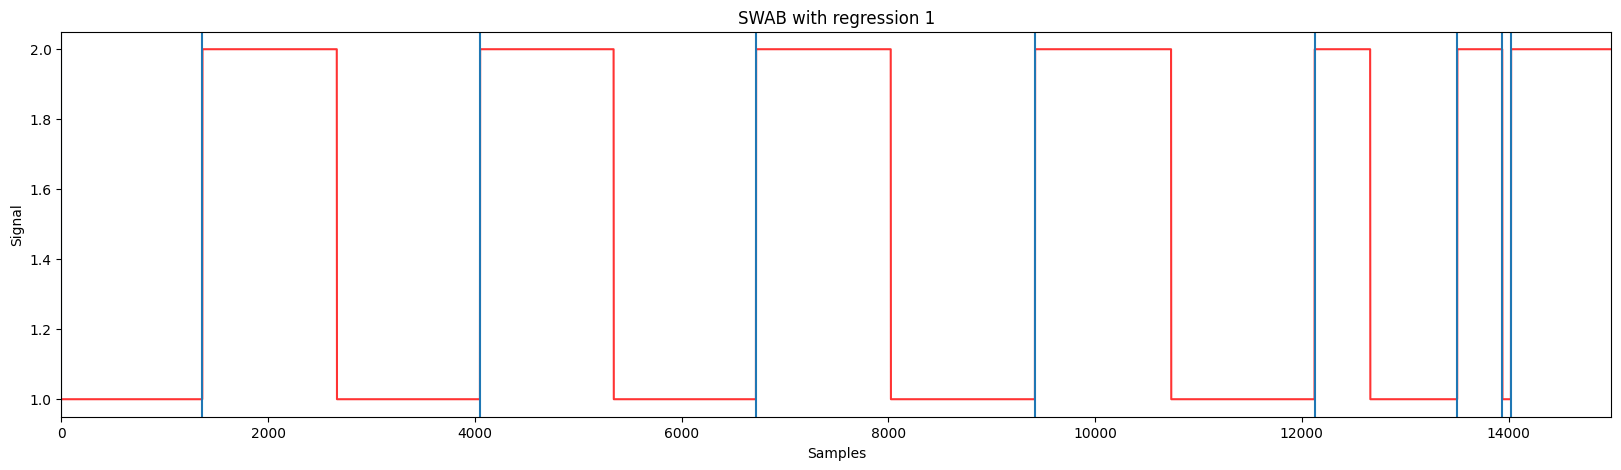

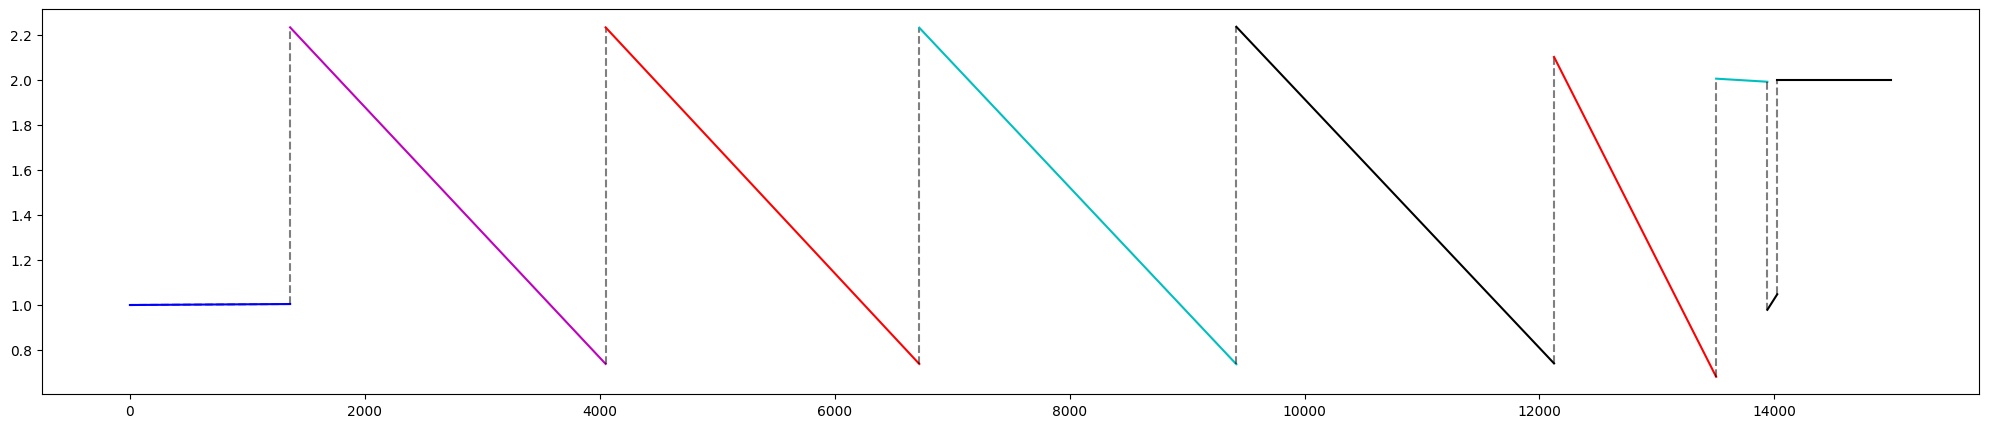

(0.9173112830088024, 0.0, 0.0, 0)

In [42]:
max_error = 1
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_swab,pre_swab,recall_swab,f1_swab 

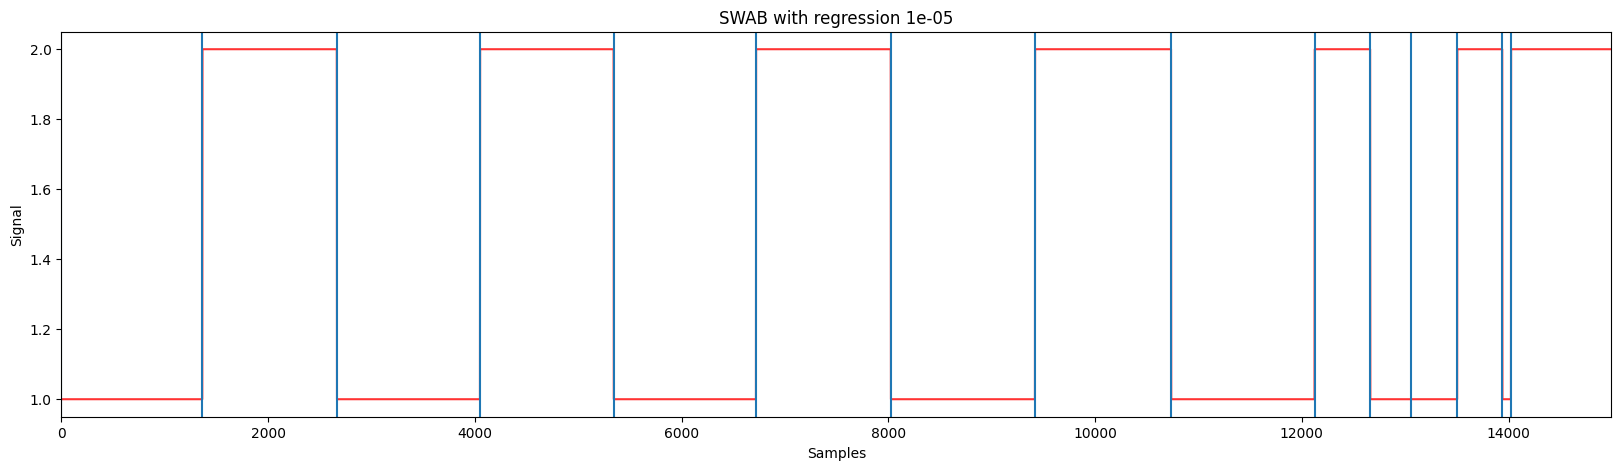

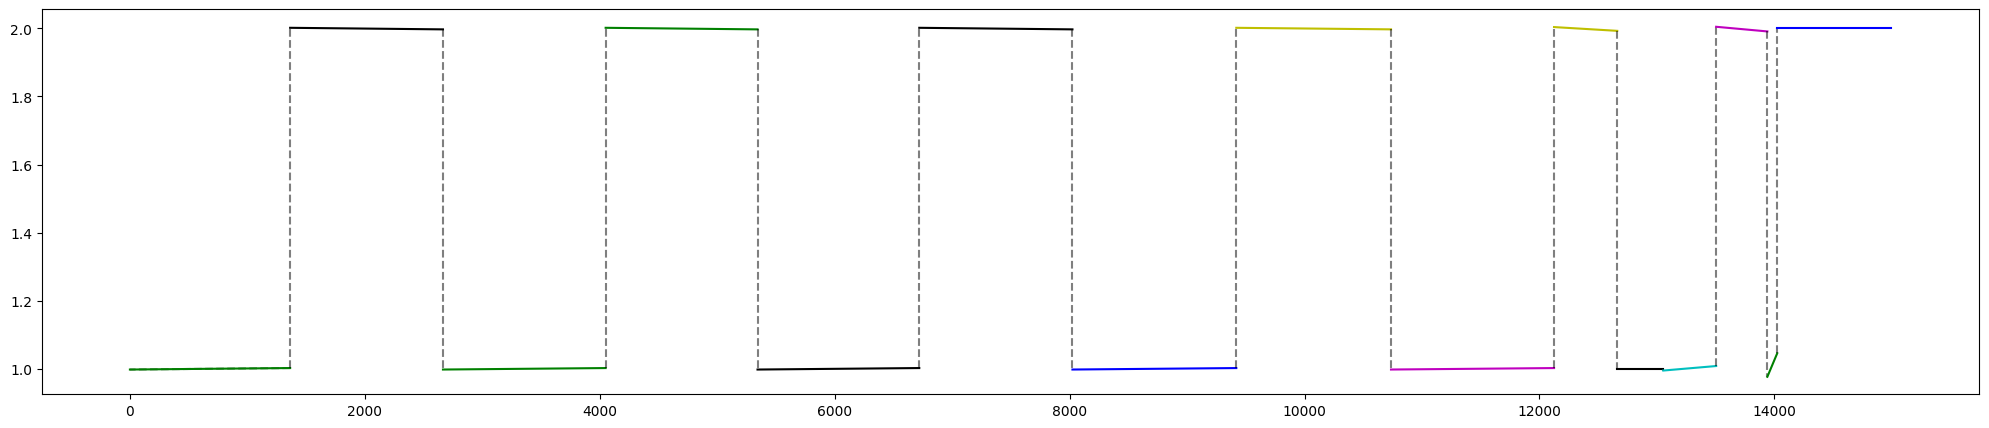

(0.9173112830088024, 0.0, 0.0, 0)

In [43]:
max_error = 0.00001
data = list(SWaT_2019_df[anomaly_feature].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(SWaT_2019_df,attack_indx,anomaly_segment)
acc_swab,pre_swab,recall_swab,f1_swab 

# Conclusion

In [48]:
range_Top_down = [20,75]
range_Bottom_up = [0.05,0.10]
range_sliding_window = [1,40]
range_swab = [0,50]

time_avg_Top_down = 54.4200
time_avg_Bottom_up = 12.2750
time_avg_sliding_window = 6.9075
time_avg_swab = (18+10.7+11.5)/3

best_Top_down = 50
best_Bottom_up = 0.075
best_sliding_window = 20
best_swab =  5

acc_topdown,pre_topdown,recall_topdown,f1_topdown
acc_btu,pre_btu,recall_btu,f1_btu
acc_sldw,pre_sldw,recall_sldw,f1_sldw
acc_swab,pre_swab,recall_swab,f1_swab

(0.9173112830088024, 0.0, 0.0, 0)

In [51]:
data = {   
    'Id' : ['P301 Status','P301 Status','P301 Status','P301 Status'],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min': [range_Top_down[0],range_Bottom_up[0], range_sliding_window[0],range_swab[0]],
    'max': [range_Top_down[1],range_Bottom_up[1],range_sliding_window[1],range_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(s)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [1,2,2,2]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min,max,Best,Time Average(s),Accuracy,Precision,Recall,F1-score,Rank
0,P301 Status,Top-down,20.00,75.0,50.000,54.4200,0.997533,0.956005,1.0,0.977508,1
1,P301 Status,Bottom-up,0.05,0.1,0.075,12.2750,0.854561,0.000000,0.0,0.000000,2
2,P301 Status,Sliding-window,1.00,40.0,20.000,6.9075,0.946052,0.000000,0.0,0.000000,2
3,P301 Status,SWAB,0.00,50.0,5.000,13.4000,0.917311,0.000000,0.0,0.000000,2


In [52]:
old_conclusion_df = pd.read_csv('exp\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\Conclusion.csv',index=False)

👉 Có thể phân ra đúng đoạn anomaly, nhưng không thể phân biệt được đoạn nào là anomaly

⚠️ Cách chọn anomaly line khác

# Feature Max-error

In [53]:
num_datapoints = np.shape(SWaT_2019_df)[0]

In [54]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 'P301 Status'
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_Top_down[0]
feature_max_error['Max(max_error)_Top_down'] = range_Top_down[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_Bottom_up[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_Bottom_up[1]
feature_max_error['Min(max_error)_SLDW'] = range_sliding_window[0]
feature_max_error['Max(max_error)_SLDW'] = range_sliding_window[1]
feature_max_error['Min(max_error)_SWAB'] = 0.1
feature_max_error['Max(max_error)_SWAB'] = 700
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = 500

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [55]:
old_feat_df = pd.read_csv('exp\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\Feature__Maxerror.csv',index=False)
feat_df

,id,Num_points,mean,median,variance,standard_deviation,mean_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,LIT 301,14996,946.637019,981.1587,8494.478007,92.165492,0.010217,-1.072911,730.7021,1112.77563,100000,500000,0.10,700.0,20000,200000,0.1,700,500
1,MV 501,14996,1.988530,2.0000,0.013205,0.114914,0.000000,133.339292,0.0000,2.00000,20,100,1.00,5.0,10,40,0.1,700,500
2,MV201,14996,1.369765,1.0000,0.244909,0.494883,0.000000,-1.470841,0.0000,2.00000,100,3000,4.00,5.0,215,300,0.1,700,500
3,MV 501,14996,1.374166,1.0000,0.234166,0.483907,0.000000,-1.729700,1.0000,2.00000,100,2000,1.00,55.0,1,15,0.1,700,500
4,P301 Status,14996,1.477527,1.0000,0.249495,0.499495,0.000067,-1.992167,1.0000,2.00000,20,75,0.05,0.1,1,40,0.1,700,500
